In [3]:
!git clone https://github.com/MTG/freesound-python

Cloning into 'freesound-python'...
remote: Enumerating objects: 385, done.
remote: Counting objects: 100% (93/93), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 385 (delta 44), reused 72 (delta 43), pack-reused 292 (from 1)
Receiving objects: 100% (385/385), 196.77 KiB | 2.77 MiB/s, done.
Resolving deltas: 100% (186/186), done.


In [6]:
!mv freesound-python/data-acquisition

In [10]:
!mkdir data-acquisition/data

In [1]:
import os
import json
import shutil
import traceback
import librosa
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd

In [2]:
download_path = "data-acquisition/data"

In [3]:
import sys
sys.path.append('./data-acquisition/freesound-python')

import freesound as fs

In [13]:
# this cell is copied from the Freesound assignment from the class Audio Signal Processing
# for Music Applications
def download_sounds_freesound(queryText = "", tag=None, duration=None, API_Key = "", outputDir = "", topNResults = 5, featureExt = '.json',
                              username=None, descriptors=[""]):
    """
    This function downloads sounds and their descriptors from freesound using the queryText and the
    tag specified in the input. Additionally, you can also specify the duration range to filter sounds
    based on duration.

    Inputs:
        (Input parameters marked with a * are optional)
        queryText (string): query text for the sounds (eg. "violin", "trumpet", "cello", "bassoon" etc.)
        tag* (string): tag to be used for filtering the searched sounds. (eg. "multisample",
                       "single-note" etc.)
        duration* (tuple): min and the max duration (seconds) of the sound to filter, eg. (0.2,15)
        username (str): username to filter by
        API_Key (string): your api key, which you can obtain from : www.freesound.org/apiv2/apply/
        outputDir (string): path to the directory where you want to store the sounds and their
                            descriptors
        topNResults (integer): number of results(sounds) that you want to download
        featureExt (string): file extension for storing sound descriptors
    output:
        This function downloads sounds and descriptors, and then stores them in outputDir. In
        outputDir it creates a directory of the same name as that of the queryText. In this
        directory outputDir/queryText it creates a directory for every sound with the name
        of the directory as the sound id. Additionally, this function also dumps a text file
        containing sound-ids and freesound links for all the downloaded sounds in the outputDir.
        NOTE: If the directory outputDir/queryText exists, it deletes the existing contents
        and stores only the sounds from the current query.
    """

    # Checking for the compulsory input parameters
    if queryText == "":
        print("\n")
        print("Provide a query text to search for sounds")
        return -1

    if API_Key == "":
        print("\n")
        print("You need a valid freesound API key to be able to download sounds.")
        print("Please apply for one here: www.freesound.org/apiv2/apply/")
        print("\n")
        return -1

    if outputDir == "" or not os.path.exists(outputDir):
        print("\n")
        print("Please provide a valid output directory. This will be the root directory for storing sounds and descriptors")
        return -1

    # Setting up the Freesound client and the authentication key
    fsClnt = fs.FreesoundClient()
    fsClnt.set_token(API_Key, "token")

    # Creating a duration filter string that the Freesound API understands
    if duration and type(duration) == tuple:
        flt_dur = " duration:[" + str(duration[0]) + " TO " + str(duration[1]) + "]"
    else:
        flt_dur = ""

    if tag and type(tag) == str:
        flt_tag = "tag:" + tag
    else:
        flt_tag = ""

    if username and type(username) == str:
        flt_user = "username:" + username
    else:
        flt_user = ""

    # Querying Freesound
    page_size = 30
    if not flt_tag + flt_dur + flt_user == "":
        qRes = fsClnt.text_search(query=queryText, filter=flt_tag + flt_dur + flt_user, sort="score", fields="id,name,previews,username,url,analysis", descriptors=','.join(descriptors), page_size=page_size, normalized=1)
    else:
        qRes = fsClnt.text_search(query=queryText, sort="score", fields="id,name,previews,username,url,analysis", descriptors=','.join(descriptors), page_size=page_size, normalized=1)

    outDir2 = os.path.join(outputDir, queryText)
    if os.path.exists(outDir2):  # If the directory exists, delete it and start fresh
        shutil.rmtree(outDir2)
    os.mkdir(outDir2)

    pageNo = 1
    sndCnt = 0
    indCnt = 0
    totalSnds = min(qRes.count, 50)  # System quits after trying to download 200 times

    # Creating directories to store output and downloading sounds and their descriptors
    downloadedSounds = []
    while True:
        if indCnt >= totalSnds:
            print("Not able to download the required number of sounds. Either there are not enough search results on Freesound for your search query and filtering constraints, or something is wrong with this script.")
            break

        sound = qRes[indCnt - ((pageNo-1) * page_size)]
        print(f"Downloading mp3 preview and descriptors for sound with ID: {str(sound.id)}")

        outDir1 = os.path.join(outputDir, queryText, str(sound.id))
        if os.path.exists(outDir1):
            shutil.rmtree(outDir1)
        os.mkdir(outDir1)

        mp3Path = os.path.join(outDir1, str(sound.previews.preview_lq_mp3.split("/")[-1]))
        ftrPath = mp3Path.replace('.mp3', featureExt)

        try:
            fs.FSRequest.retrieve(sound.previews.preview_lq_mp3, fsClnt, mp3Path)

            # Safely access descriptors without eval
            features = {desc: getattr(sound.analysis, desc, None) for desc in descriptors}

            # Save features to a JSON file
            with open(ftrPath, 'w') as ftrFile:
                json.dump(features, ftrFile)

            sndCnt += 1
            downloadedSounds.append([str(sound.id), sound.url])
        except Exception as e:
            print(f"Error downloading sound ID {sound.id}: {e}")
            print(traceback.format_exc())
            shutil.rmtree(outDir1)

        indCnt += 1

        if indCnt % page_size == 0:
            qRes = qRes.next_page()
            pageNo += 1

        if sndCnt >= topNResults:
            break

    # Dump the list of files and Freesound links
    with open(os.path.join(outDir2, f'{queryText}_SoundList.txt'), 'w') as fid:
        for elem in downloadedSounds:
            fid.write('\t'.join(elem) + '\n')


In [7]:
# this helper is copied from my final assignment in the ASPMA class
def random_rec_paths( instrument="trumpet", n=3, storage_dir="testDownload" ):
    """
    Return n random file paths to recordings of the specified instrument.

    Parameters:
        instrument (str): the name of the query (also name of a directory in storage_dir)
        n (int): number of paths to return
        storage_dir (str): path to the directory where freesound download script outputs to
    """
    instrument_path = f"{storage_dir}/{instrument}"

    # freesound example ids
    example_ids = os.listdir( instrument_path )

    # do not consider non-directory files, like .DS_Store
    removables = []
    for ex in example_ids:
        if not os.path.isdir( f"{instrument_path}/{ex}" ):
            removables.append( ex )
    for ex in removables:
        example_ids.remove( ex )

    exs = np.random.choice( example_ids, size=n, replace=False )

    # for each example, find the name of the mp3 file
    mp3_paths = []
    for ex in exs:
        for filename in os.listdir( f"{instrument_path}/{ex}" ):
            if filename.endswith( ".mp3" ):
                mp3_paths.append(
                    f"{instrument_path}/{ex}/{filename}"
                )

    return mp3_paths

In [8]:
def plot_waveform_and_spectrogram( x, sr ):
    """
    Parameters:
        x (numpy.ndarray): audio samples
        sr (int): sample rate
    """
    plt.figure(figsize=(12, 6))

    # Plot waveform
    plt.subplot(2, 1, 1)
    librosa.display.waveshow(x, sr=sr)
    plt.title("Waveform")
    plt.xlabel("Time (s)")
    plt.xlim( [ 0, len( x ) / sr ] )
    plt.ylabel("Amplitude")

    # Compute and plot spectrogram
    plt.subplot(2, 1, 2)
    S = librosa.stft(x)
    S_db = librosa.amplitude_to_db(np.abs(S), ref=np.max)
    librosa.display.specshow(S_db, sr=sr, x_axis="time", y_axis="log")
    plt.colorbar(label="dB")
    plt.title("Spectrogram")

    plt.tight_layout()
    plt.show()

In [9]:
# replace with the location of your own Freesound API key
API_Key = None
API_Key_path = "/Users/morehovschi/freesound_api_key"
with open( API_Key_path, "r" ) as f:
    # read API key and omit the last character (\n)
    API_Key = f.readlines()[ 0 ][ :-1 ]

In [64]:
download_sounds_freesound( queryText = "crickets", duration=(5,10), API_Key=API_Key,
                           outputDir=download_path, topNResults=30 )

In [14]:
cricket_paths = random_rec_paths( instrument="crickets", n=30, storage_dir=download_path )

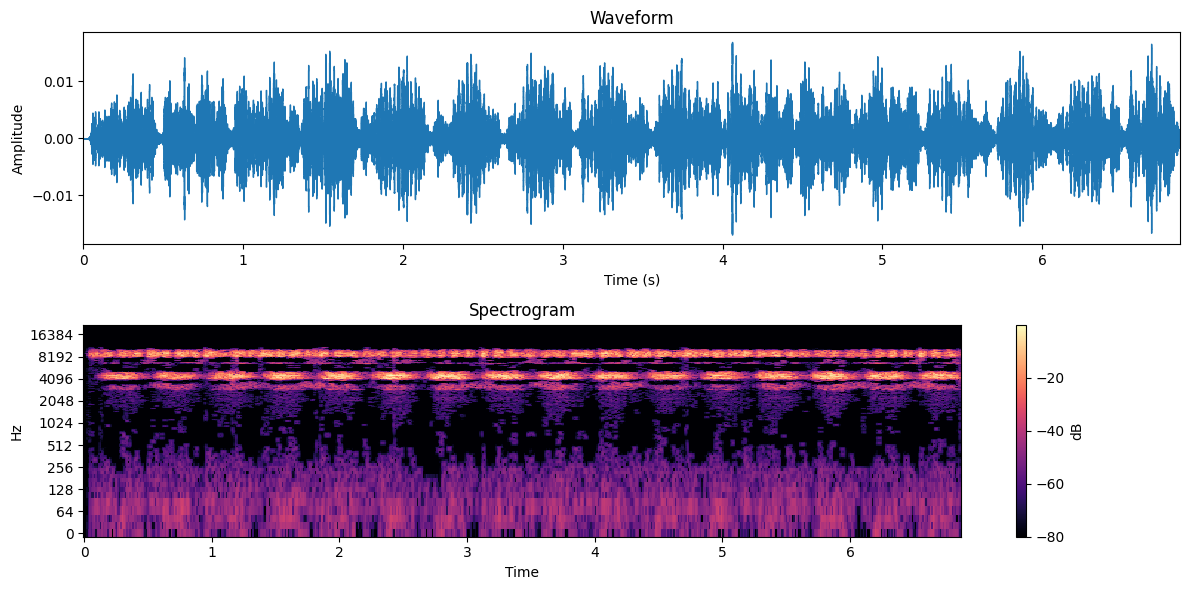

In [16]:
x, sr = librosa.load( cricket_paths[ 26 ], sr=44100, mono=True )
plot_waveform_and_spectrogram( x, sr )
ipd.Audio( x, rate=sr, normalize=True )

In [85]:
download_sounds_freesound( queryText = "helicopter", duration=( 5,10 ), API_Key=API_Key,
                           outputDir=download_path, topNResults=30 )

In [15]:
heli_paths = random_rec_paths( instrument="helicopter", n=30, storage_dir=download_path )

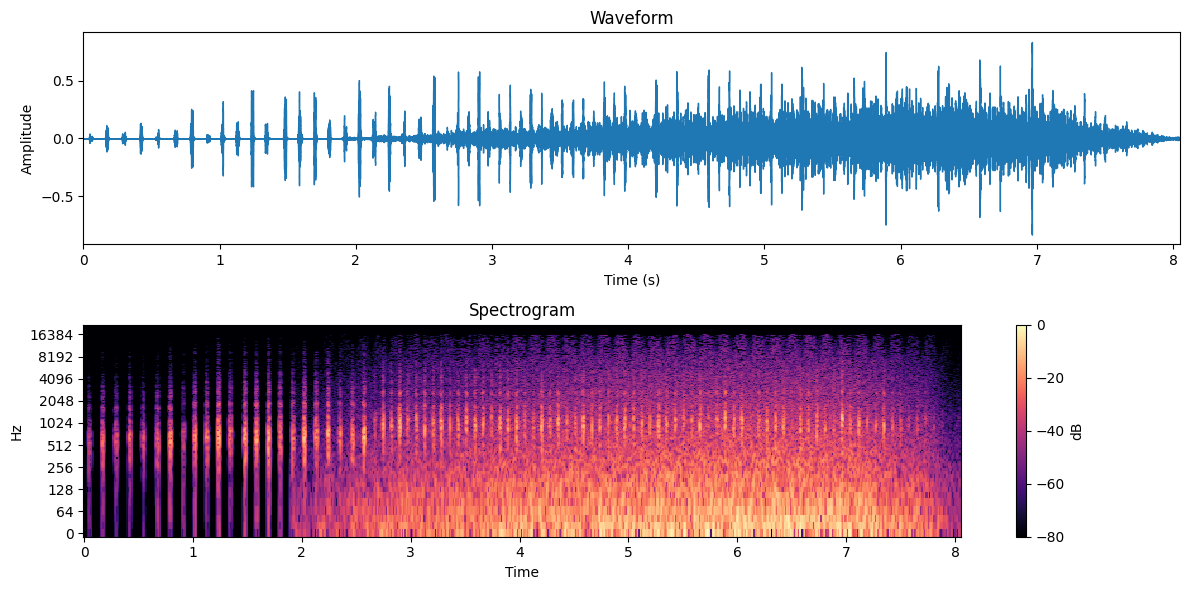

In [13]:
x, sr = librosa.load( heli_paths[ 21 ], sr=None, mono=True )
plot_waveform_and_spectrogram( x, sr )
ipd.Audio( x, rate=sr, normalize=True )

In [ ]:
download_sounds_freesound( queryText = "waterfall", duration=(5,10), API_Key=API_Key,
                           outputDir=download_path, topNResults=30 )

In [16]:
waterfall_paths = random_rec_paths( instrument="waterfall", n=30, storage_dir=download_path )

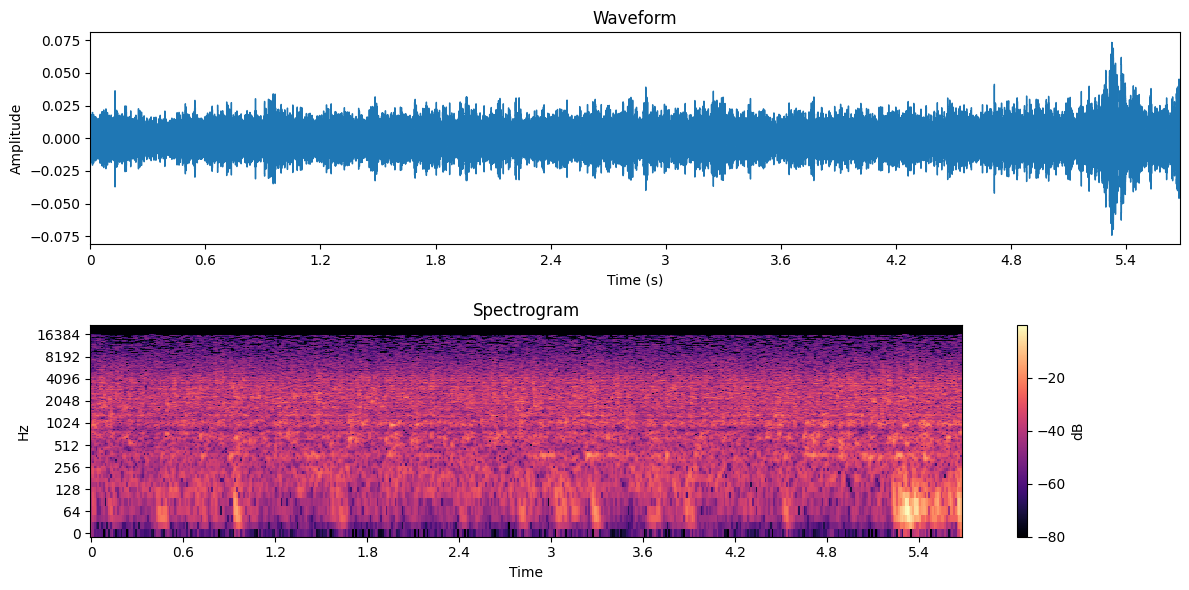

In [30]:
x, sr = librosa.load( waterfall_paths[ 4 ], sr=44100, mono=True )
plot_waveform_and_spectrogram( x, sr )
ipd.Audio( x, rate=sr, normalize=True )

## To DAC

In [18]:
import soundfile as sf
import dac
from audiotools import AudioSignal

# initialize DAC model
model_path = dac.utils.download(model_type="44khz")
model = dac.DAC.load(model_path)

In [20]:
target_dir = "data-acquisition/data-out/dac-train"

In [21]:
def mp3_to_dac( path, target_dir ):
    """
    Reads 'path' pointing to an mp3, creates an intermediary, cropped
    wav version of the audio, and then writes a compressed version as a
    .dac file in the target dir.

    The 'path' has a structure as output by the freesound download function,
    where the second to last element is the freesound id and the third to
    last is the used query (treated here as the class name).
    """
    path_elements = path.split( "/" )
    freesound_id = path_elements[ -2 ]
    class_name = path_elements[ -3 ]
    wav_path = path.replace( ".mp3", ".wav" )
    
    # load source mp3 and crop the first 5 seconds
    x, sr = librosa.load( path, sr=44100 )
    x = x[ : sr * 5 - 1 ]
    
    # save audio to wav
    sf.write( wav_path, x, sr )
    
    # encode to DAC format
    signal = AudioSignal( wav_path )
    signal = signal.cpu()
    x_dac = model.compress(signal, n_quantizers=4 )

    dac_path = f"{target_dir}/{class_name}--p1-01.00--fid-{freesound_id}--p3-00.dac"
    x_dac.save( dac_path )

    return wav_path, dac_path

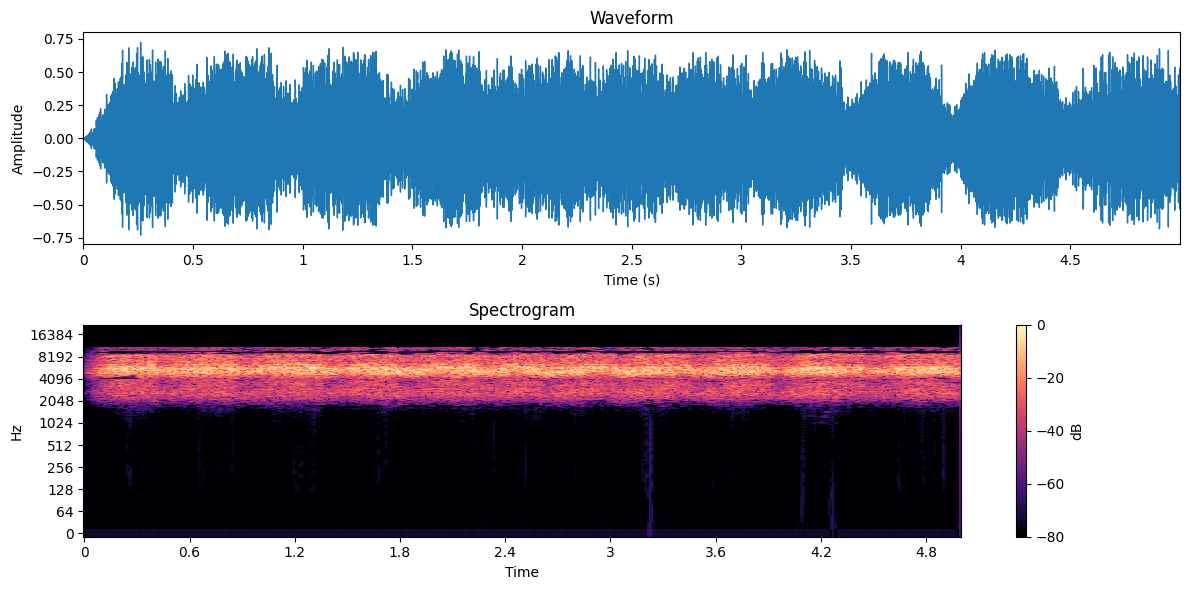

In [22]:
path = cricket_paths[ 0 ]
wav_path, dac_path = mp3_to_dac( path, target_dir )
x, sr = librosa.load( wav_path, sr=44100 )
plot_waveform_and_spectrogram( x, sr )
ipd.Audio( x, rate=sr )

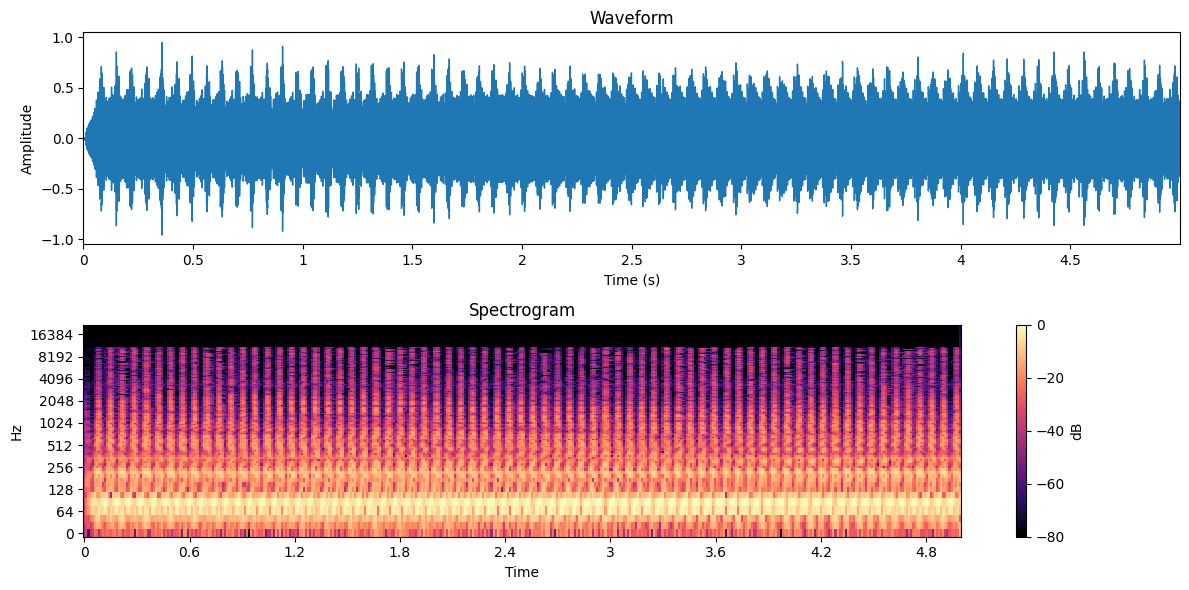

In [23]:
path = heli_paths[ 10 ]
wav_path, dac_path = mp3_to_dac( path, target_dir )
x, sr = librosa.load( wav_path, sr=44100 )
plot_waveform_and_spectrogram( x, sr )
ipd.Audio( x, rate=sr )

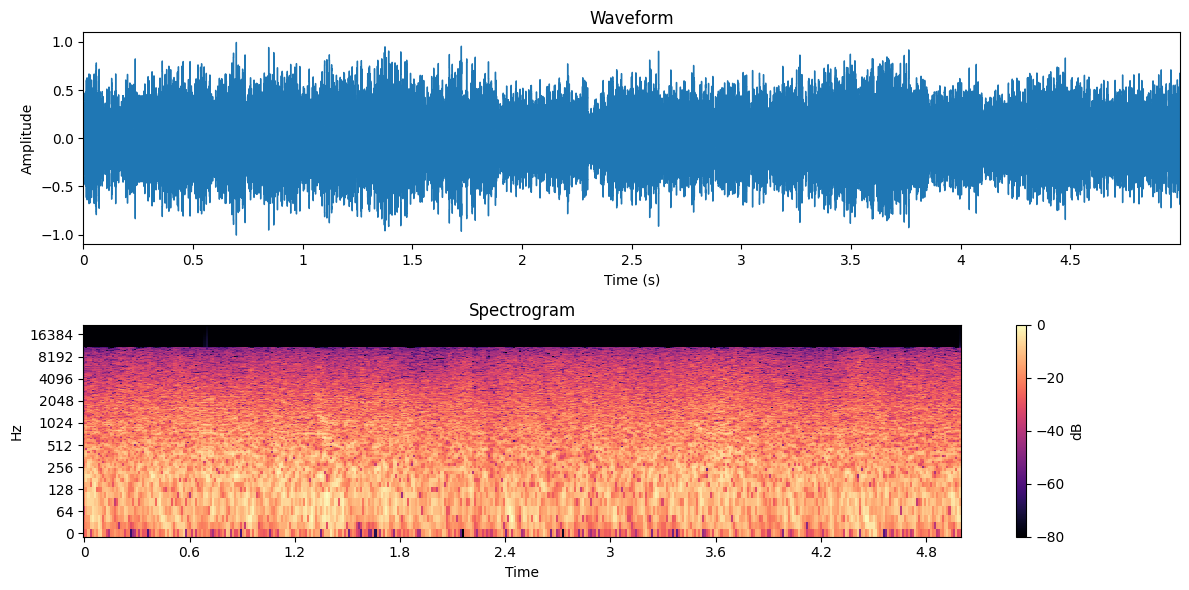

In [24]:
path = waterfall_paths[ 0 ]
wav_path, dac_path = mp3_to_dac( path, target_dir )
x, sr = librosa.load( wav_path, sr=44100 )
plot_waveform_and_spectrogram( x, sr )
ipd.Audio( x, rate=sr )

Now extract validation data

In [25]:
target_dir = "data-acquisition/data-out/dac-val"

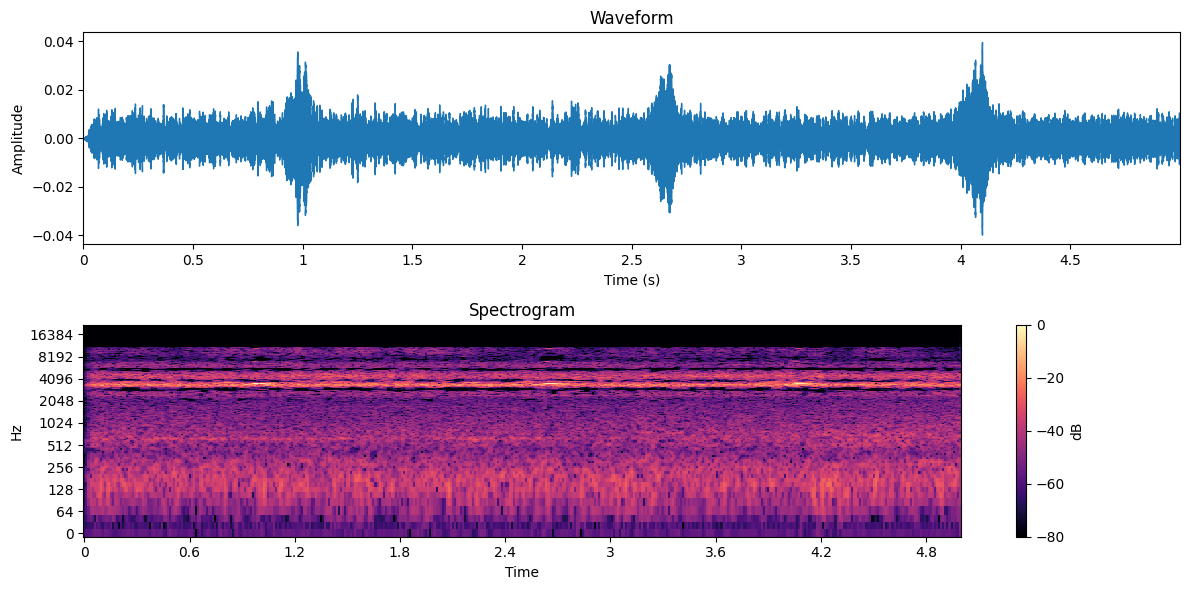

In [26]:
path = cricket_paths[ 2 ]
wav_path, dac_path = mp3_to_dac( path, target_dir )
x, sr = librosa.load( wav_path, sr=44100 )
plot_waveform_and_spectrogram( x, sr )
ipd.Audio( x, rate=sr )

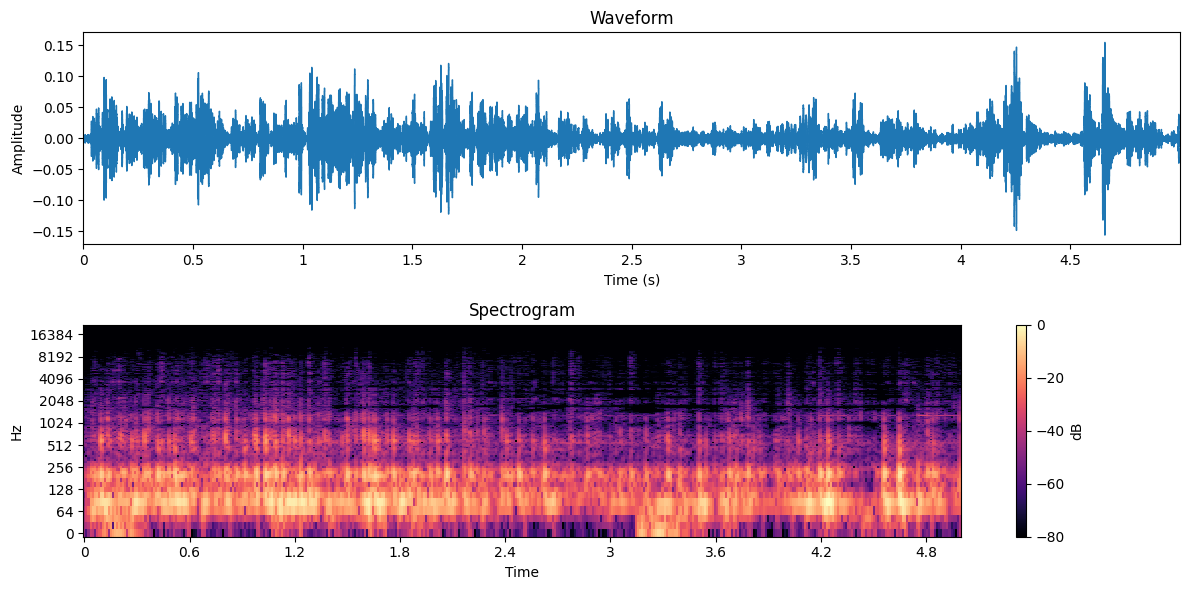

In [27]:
path = heli_paths[ 11 ]
wav_path, dac_path = mp3_to_dac( path, target_dir )
x, sr = librosa.load( wav_path, sr=44100 )
plot_waveform_and_spectrogram( x, sr )
ipd.Audio( x, rate=sr )

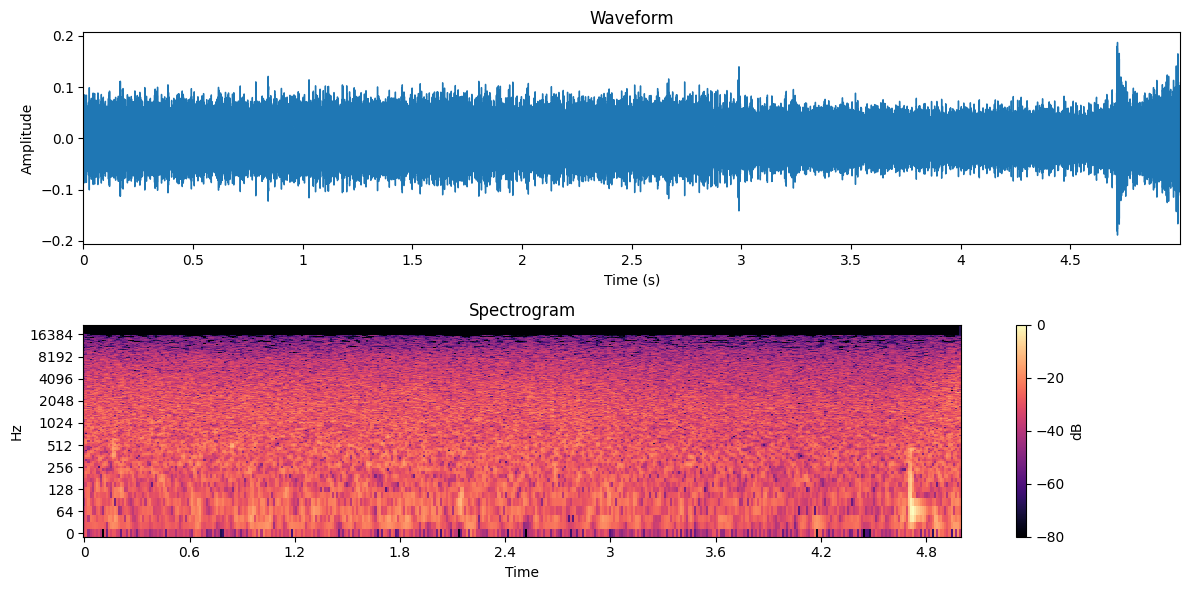

In [28]:
path = waterfall_paths[ 1 ]
wav_path, dac_path = mp3_to_dac( path, target_dir )
x, sr = librosa.load( wav_path, sr=44100 )
plot_waveform_and_spectrogram( x, sr )
ipd.Audio( x, rate=sr )

#### DEBUG

In [31]:
!ls data-acquisition/data-out/dac-train

crickets--p1-01.00--fid-672332--p3-00.dac
helicopter--p1-01.00--fid-413655--p3-00.dac
waterfall--p1-01.00--fid-108381--p3-00.dac


In [33]:
x = dac.DACFile.load("data-acquisition/data-out/dac-train/crickets--p1-01.00--fid-672332--p3-00.dac")

In [34]:
x.codes.shape

torch.Size([1, 4, 576])

In [90]:
!ls testdata/dac-train

DSApplause--numClappers_exp-00.50--c-02--x-92.dac
DSBugs--busybodyFreqFactor-00.50--c-00--x-90.dac
DSPistons--rate_exp-00.50--c-00--x-90.dac
DSWind--strength-00.50--c-00--x-90.dac


In [91]:
x = dac.DACFile.load("testdata/dac-train/DSApplause--numClappers_exp-00.50--c-02--x-92.dac")

In [95]:
x.codes.shape

torch.Size([1, 4, 431])